In [1]:
from random import randint
import pandas as pd
import numpy as np
from statsmodels.stats.inter_rater import fleiss_kappa
from scipy.stats import norm
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import spearmanr
from tqdm.auto import tqdm
from seaborn import heatmap

pd.set_option('display.max_colwidth', 256)

In [2]:
def load_data():
    res1 = pd.read_csv('responses/Batch_5161802_batch_results.csv')
    res2 = pd.read_csv('responses/Batch_5162734_batch_results.csv')
    res = pd.concat([res1,res2])
    res['Answer.equal.label'] = res['Answer.equal.label'].replace('Arugment 1','Argument 1') # Fix spelling mistake in one of the files
    return res

def get_user_response_overview(res_df=load_data()):
    """Get a per user overview of all their annotations."""
    res = res_df

    res['norm_ans'] = res['Answer.equal.label'].apply(lambda x: int(x.split(' ')[1])-1) # Have a 0/1 column to see fraction of answers between labels.
    control_rows = res[(res['Input.dim2'].str.contains('control')) | (res['Input.dim1'].str.contains('control'))] 

    def get_failed_rows(df):
        """See the rows where an annotator failed a control sample"""
        df = df.copy()
        df["failed"] = None
        for i, row in df.iterrows():
            if ((row['Answer.equal.label'] == 'Argument 2' and 'control' in row['Input.dim2'])
            or (row['Answer.equal.label'] == 'Argument 1' and 'control' in row['Input.dim1'])):
                df.loc[i,"failed"] = True
            else:
                df.loc[i,"failed"] = False
        df = df[df['failed']==True]
        return df.copy() # Copying avoids weird interactions

    failed_controls = get_failed_rows(control_rows)

    frac_ans = pd.DataFrame(res.groupby('WorkerId')['norm_ans'].mean()).rename(columns={'norm_ans':'percent_arg_2'})
    num_ans = pd.DataFrame(res.groupby('WorkerId')['norm_ans'].count()).rename(columns={'norm_ans':'count'})
    work_mean = pd.DataFrame(res.groupby('WorkerId')['WorkTimeInSeconds'].mean()).rename(columns={'WorkTimeInSeconds':'avg_time_per_task'})
    controls_seen = pd.DataFrame(control_rows.groupby('WorkerId')['norm_ans'].count()).rename(columns={'norm_ans':'seen_controls'})
    controls_failed = pd.DataFrame(failed_controls.groupby('WorkerId')['norm_ans'].count()).rename(columns={'norm_ans':'failed_controls'})

    df_info = num_ans.join([frac_ans, work_mean, controls_seen, controls_failed
                        ]).sort_values('count',ascending=False)
    df_info = df_info.fillna(0)
    df_info['control_failed_frac'] = df_info['failed_controls']/df_info['seen_controls']
    return df_info

def get_rejected_users(overview_table=get_user_response_overview()):
    """Get the users which fail our definitions of an unreliable annotator."""
    control_failed_too_high = set(overview_table[overview_table['control_failed_frac'] > 0.25].index)
    too_few_annotations = set(overview_table[overview_table['count'] < 10].index)
    no_controls_seen = set(overview_table[overview_table['seen_controls'] == 0].index)

    rejected_users = control_failed_too_high | too_few_annotations | no_controls_seen
    return rejected_users

In [3]:
res_full = load_data()
res_rejected = res_full.set_index("WorkerId").drop(index=get_rejected_users()).reset_index()
print(f"Amount of rejected users: {len(get_rejected_users())}")
print(f"Original data had {len(res_full)} rows. After rejecting users we have {len(res_rejected)}")

Amount of rejected users: 16
Original data had 2160 rows. After rejecting users we have 2061


## Ranking dimensions

In [4]:
def btl(iterations, matches):
    """Algorithm for the Bradley-Terry model"""
    scores = np.ones(matches.shape[0])
    for i in range(iterations):
        for idx,prob in enumerate(scores):
            numerator = []
            denominator = []
            for idy, prob2 in enumerate(scores):
                if idx!= idy:
                    wins = matches[idx][idy]
                    losses = matches[idy][idx]
                    prob_ratio_num = prob2/(prob+prob2)
                    prob_ratio_denum = 1/(prob+prob2)
                    numerator.append(wins*prob_ratio_num)
                    denominator.append(losses*prob_ratio_denum)
            scores[idx] = sum(numerator)/sum(denominator)

        normalize_constant = np.prod(scores)**(1/len(scores))
        scores = scores/normalize_constant
    return scores

def get_btl_ranking(res:pd.core.frame.DataFrame):
    """
    From our response batch file, run the Bradley-Terry model and geth their ranking.
    Return the dimensions, sorted by the best performing dimension first
    """
    social_dims = np.array(['baseline','support', 'knowledge', 'conflict', 'similarity', 'fun', 'status', 'trust', 'identity'])
    social_dim_mapping = {dim:idx for idx,dim in enumerate(social_dims)}
    scores_matrix = np.zeros((len(social_dim_mapping),len(social_dim_mapping)))
    for idx,row in res.iterrows():
        if ('control' not in row['Input.dim2']) and ('control' not in row['Input.dim1']):
            winner = int(row['Answer.equal.label'].split(' ')[1])
            loser = (winner%2)+1
            winner_dim = social_dim_mapping[row[f'Input.dim{winner}']]
            loser_dim = social_dim_mapping[row[f'Input.dim{loser}']]
            scores_matrix[winner_dim,loser_dim] +=1
    btl_scores = btl(100,scores_matrix)
    sorting = np.argsort(btl_scores)
    return sorted(btl_scores,reverse=True),social_dims[sorting][::-1]

In [5]:
btl_scores, ranking = get_btl_ranking(res_rejected)
print(ranking)
print(btl_scores)

['knowledge' 'baseline' 'status' 'trust' 'support' 'identity' 'similarity'
 'conflict' 'fun']
[8.630919787555534, 3.304328261361524, 2.43930241299982, 2.2998099337495397, 1.0276971534587132, 0.6573619229955617, 0.552027341301756, 0.16491502662979546, 0.10162759030430976]


/tmp/ipykernel_16136/2690581937.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([dim.title() for dim in ranking],rotation=0)


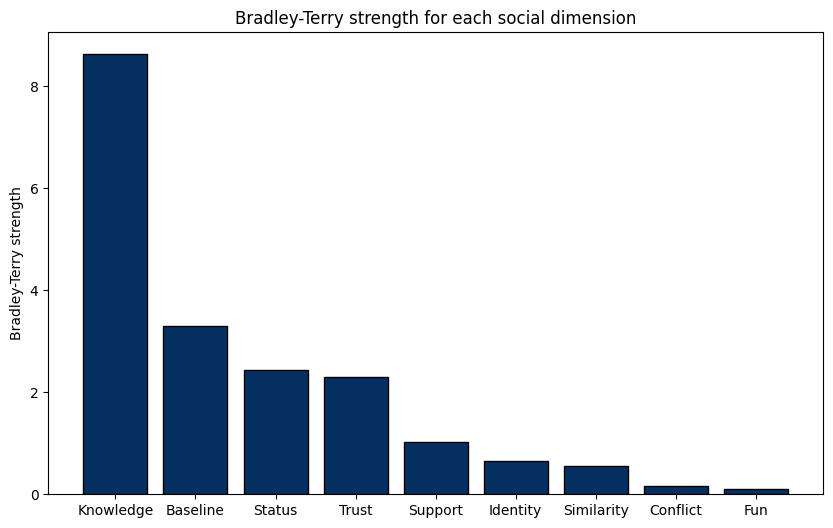

In [6]:
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(ranking,btl_scores,color=plt.get_cmap("RdBu")(255),edgecolor='black')
ax.set_xticklabels([dim.title() for dim in ranking],rotation=0)
ax.set_ylabel('Bradley-Terry strength')
ax.set_title('Bradley-Terry strength for each social dimension')
plt.savefig('../misc/images_for_report/btl_strength_scores.svg')
plt.show();

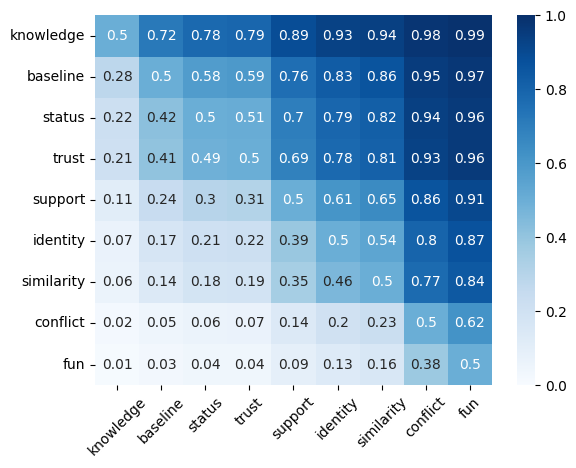

In [7]:
def get_probability_heatmap(btl_scores,btl_ranking,save=False):
    social_dims = np.array(ranking)
    idx_to_dim = {idx:dim for idx,dim in enumerate(social_dims)}
    prob_matrix = np.zeros((len(idx_to_dim),len(idx_to_dim)))
    for x in idx_to_dim:
        for y in idx_to_dim:
            prob_matrix[x,y] = round(btl_scores[x]/(btl_scores[x]+btl_scores[y]),2)
    ax = heatmap(prob_matrix,cmap="Blues",annot=True,vmin=0,vmax=1)
    ax.set_xticklabels([idx_to_dim[i] for i in range(len(idx_to_dim))],rotation=45)
    ax.set_yticklabels([idx_to_dim[i] for i in range(len(idx_to_dim))],rotation=0)
    if save:
        plt.savefig("../misc/images_for_report/heatmap_annotations_probabilities.svg")
    plt.show()
get_probability_heatmap(btl_scores,ranking,save=True)

### Annotation scores

In [8]:
def get_number_of_matchups(res,*,use_control=False):
    """Get the unique matchups, unshuffle the two argument columns"""
    seen = set()
    for idx,row in res.iterrows():
        if (('control' in row['Input.dim2']) or ('control' in row['Input.dim1'])) and (not use_control): # If the row is control, and we dont want to use control
            continue
        arg_in_order = tuple(sorted((row['Input.url1'],row['Input.url2'])))
        seen.add(arg_in_order)
    return len(seen)

In [9]:
def get_matchup_results(res,*,use_control=False, get_row_matchup=False):
    """
    For each matchup, get the number of annotations for argument 1 and 2.
    Returns an Nx2 matrix, with N being the number of unique matchups.
    """
    row_matchup = {}
    matches_seen = 0
    size_score_matrix = get_number_of_matchups(res,use_control=use_control)
    scores_matrix = np.zeros((2,size_score_matrix))
    for idx,row in res.iterrows():
        if (('control' in row['Input.dim2']) or ('control' in row['Input.dim1'])) and (not use_control):
            continue
        winner = int(row['Answer.equal.label'].split(' ')[1])-1
        arg_in_order = tuple(sorted((row['Input.url1'],row['Input.url2'])))
        if arg_in_order[0] == row['Input.url1']:
            pass
        else:
            winner = (winner+1)%2
        if arg_in_order not in row_matchup:
            row_matchup[arg_in_order] = matches_seen
            matches_seen+=1
        use_col = row_matchup[arg_in_order]
        scores_matrix[winner,use_col]+=1

    if get_row_matchup:
        return scores_matrix.T, row_matchup
    return scores_matrix.T

In [10]:
def cuzick_fleiss_kappa(scores):
    """
    Fleiss calculation per https://doi.org/10.1177/014662167900300410.
    Returns the inter annotator agreement
    """
    N = scores.shape[0]
    judgements_per_sample = np.sum(scores,axis=1) # contains n_i from paper
    positive_judgements = scores[:,0] # contains x_i from paper
    p_i = positive_judgements/judgements_per_sample
    q_i = 1-p_i
    n_bar = (1/N) * sum(judgements_per_sample) # mean judges_per_subject
    
    proportion_pos = (1/(N*n_bar)) * sum(positive_judgements) # p_bar in paper
    proportion_neg = 1-proportion_pos # q_bar
    
    numerator = sum(judgements_per_sample*p_i*q_i)
    denominator = N*(n_bar-1)*proportion_pos*proportion_neg
    return 1-(numerator/denominator)

In [11]:
cuzick_fleiss_kappa(get_matchup_results(res_full))

0.518588303972157

In [12]:
cuzick_fleiss_kappa(get_matchup_results(res_full,use_control=True))

0.5698440498643857

#### Excluding users

In [13]:
cuzick_fleiss_kappa(get_matchup_results(res_rejected))

0.5161323498776087

In [14]:
cuzick_fleiss_kappa(get_matchup_results(res_rejected,use_control=True))

0.5724838444552057

## Excluding annotations based on agreement level

In [15]:
overview_table = get_user_response_overview()

In [16]:
def agreement_per_match_frac(matchup_results):
    return np.max(matchup_results,axis=1)/np.sum(matchup_results,axis=1)

/tmp/ipykernel_16136/64777468.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  scores[idx] = sum(numerator)/sum(denominator)
/tmp/ipykernel_16136/64777468.py:12: RuntimeWarning: invalid value encountered in double_scalars
  prob_ratio_num = prob2/(prob+prob2)


  0%|          | 0/11 [00:00<?, ?it/s]

/home/danie/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:112: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


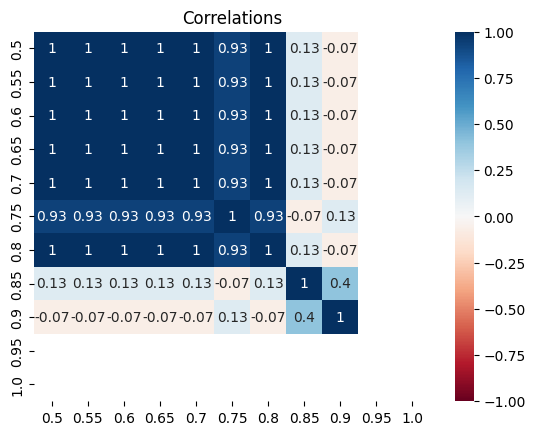

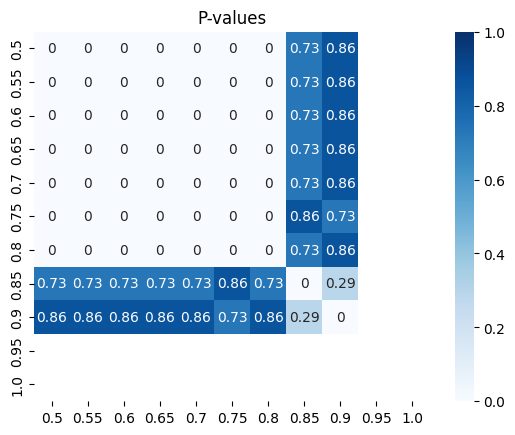

In [17]:
def drop_matches(results, matches):
    mask = np.full(shape=(len(results),), fill_value=False)
    for match in matches:
        mask |= (
            ((results["Input.url1"]==match[0]) & (results["Input.url2"]==match[1])) #Results match the match
            |
            ((results["Input.url1"]==match[1]) & (results["Input.url2"]==match[0])) #Results match the match, but are flipped
        )
    return results[~mask]

def ranking_vary_threshold(results):
    """
    Run Bradley-Terry on the data, with varying thresholds of 
    stepsize 0.5 to 1 of minimum annotator agreement per matchup.
    """
    results = results[~results["Input.dim1"].str.contains("control")] #Filter out control samples in col1
    results = results[~results["Input.dim2"].str.contains("control")] #Filter out control samples in col2
    matchup_results, row_matchup = get_matchup_results(results,use_control=False, get_row_matchup=True) #Control and rejected users are nont in this, so these arguments are irrelevant.
    agreement = agreement_per_match_frac(matchup_results)

    unique_agreement = np.linspace(0.5, 1, 10+1).round(2)
    agreement_df = pd.DataFrame.from_dict(row_matchup, orient="index").sort_values(0).reset_index().drop(columns=[0]).rename(columns={"index":"match"})
    agreement_df["agreement"] = agreement
    
    btl_scores_list, ranking_list, num_samples = [], [], []
    for threshold in unique_agreement:
        thresholded_results = drop_matches(results, agreement_df[agreement_df["agreement"]<threshold]["match"])
        num_samples.append(len(thresholded_results))
        btl_scores, ranking = get_btl_ranking(thresholded_results)
        btl_scores_list.append(btl_scores)
        ranking_list.append(ranking)
    
    return unique_agreement, btl_scores_list, ranking_list, num_samples

def ranking_stability(*args, **kwargs):
    """
    Between every pairs of thresholds, get the Speaman correlation between the rankings.
    """
    unique_agreement, btl_scores_list, ranking_list, num_samples = ranking_vary_threshold(*args, **kwargs)
    btl_invalid = list(map(np.any, map(np.isnan, btl_scores_list)))

    m = pd.DataFrame(np.zeros(shape=(len(unique_agreement), len(unique_agreement))))
    m.columns = unique_agreement
    m.index = unique_agreement

    m_significance = pd.DataFrame(np.zeros(shape=(len(unique_agreement), len(unique_agreement))))
    m_significance.columns = unique_agreement
    m_significance.index = unique_agreement

    
    for i in tqdm(range(m.shape[0])):
        for j in range(m.shape[1]):
            if btl_invalid[i] or btl_invalid[j]:
                m.iloc[i,j] = np.nan
                m_significance.iloc[i,j] = np.nan
                continue
            m.iloc[i,j] = round(spearmanr(ranking_list[i], ranking_list[j]).correlation,2)
            m_significance.iloc[i,j] = round(spearmanr(ranking_list[i], ranking_list[j]).pvalue,2)

    return m, m_significance

matrix, matrix_significance = ranking_stability(res_rejected)
heatmap(matrix, vmin=-1, vmax=1, center=0, cmap="RdBu", annot=True)
plt.title("Correlations")
plt.savefig("../misc/images_for_report/varying_agreement_correlations.svg")

plt.figure()
heatmap(matrix_significance, vmin=0, vmax=1, cmap="Blues", annot=True)
plt.title("P-values")
plt.savefig("../misc/images_for_report/varying_agreement_pvalues.svg")

In [18]:
bradley_terry_df = pd.DataFrame(ranking_vary_threshold(res_rejected)).T.rename(columns={0:"Threshold", 1:"Scores", 2:"Ranking", 3:"#Samples"})
bradley_terry_df

/tmp/ipykernel_16136/64777468.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  scores[idx] = sum(numerator)/sum(denominator)
/tmp/ipykernel_16136/64777468.py:12: RuntimeWarning: invalid value encountered in double_scalars
  prob_ratio_num = prob2/(prob+prob2)


,Threshold,Scores,Ranking,#Samples
0,0.5,"[8.630919787555534, 3.304328261361524, 2.43930241299982, 2.2998099337495397, 1.0276971534587132, 0.6573619229955617, 0.552027341301756, 0.16491502662979546, 0.10162759030430976]","[knowledge, baseline, status, trust, support, identity, similarity, conflict, fun]",1716
1,0.55,"[9.92736678347517, 3.3793126128749345, 2.4772493064826215, 2.433650936787765, 1.0496314366504527, 0.6243957097889051, 0.4989032853866148, 0.17497813562275027, 0.08641968363478038]","[knowledge, baseline, status, trust, support, identity, similarity, conflict, fun]",1656
2,0.6,"[10.02233183225099, 3.4076210499630255, 2.497944394450926, 2.4546303038087034, 1.0975825662835401, 0.6250006980912332, 0.49787931161728627, 0.1626656261562092, 0.08595546606119928]","[knowledge, baseline, status, trust, support, identity, similarity, conflict, fun]",1647
3,0.65,"[12.086884828138334, 3.799012380038064, 2.8760539136941885, 2.8259191534097092, 1.2353884853388357, 0.5591168911851572, 0.42651574143260446, 0.15449160456557132, 0.05887244076917388]","[knowledge, baseline, status, trust, support, identity, similarity, conflict, fun]",1513
4,0.7,"[12.236549201053224, 3.9326096619533066, 2.9651292503240296, 2.761658309438804, 1.3015861868214365, 0.5383552932907537, 0.4326640908900628, 0.14186503431971076, 0.0590035967526925]","[knowledge, baseline, status, trust, support, identity, similarity, conflict, fun]",1450
5,0.75,"[16.353120860868522, 3.9218006990771554, 3.2947766514652015, 3.018324927609195, 1.4173762009750834, 0.5464016575565326, 0.39606002187461564, 0.08599996343871365, 0.0594381721647157]","[knowledge, baseline, trust, status, support, identity, similarity, conflict, fun]",1272
6,0.8,"[18.45258018618745, 4.067585575212039, 3.212704215924791, 3.1387257699802005, 1.4506762514573457, 0.5548396167414867, 0.3961223247485829, 0.08332886079116686, 0.049730102658280775]","[knowledge, baseline, status, trust, support, identity, similarity, conflict, fun]",1157
7,0.85,"[20.531046664864053, 3.964111688745727, 3.911224128722575, 3.82067705216377, 1.6414157114071743, 0.5505279206755894, 0.33971261621989535, 0.07260601737005165, 0.036889924583017625]","[knowledge, trust, baseline, status, support, identity, similarity, conflict, fun]",998
8,0.9,"[80.1919528399595, 5.188240539093001, 5.050661264053645, 2.5896554158970813, 2.385730704763284, 0.4323479334233816, 0.24545784309705385, 0.04355884860314281, 0.01666290708851789]","[knowledge, trust, status, baseline, support, identity, similarity, conflict, fun]",821
9,0.95,"[nan, nan, nan, nan, nan, nan, nan, nan, nan]","[identity, trust, status, fun, similarity, conflict, knowledge, support, baseline]",581


/tmp/ipykernel_16136/2534662275.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([dim.title() for dim in btl_85['Ranking'].iloc[0]],rotation=0)


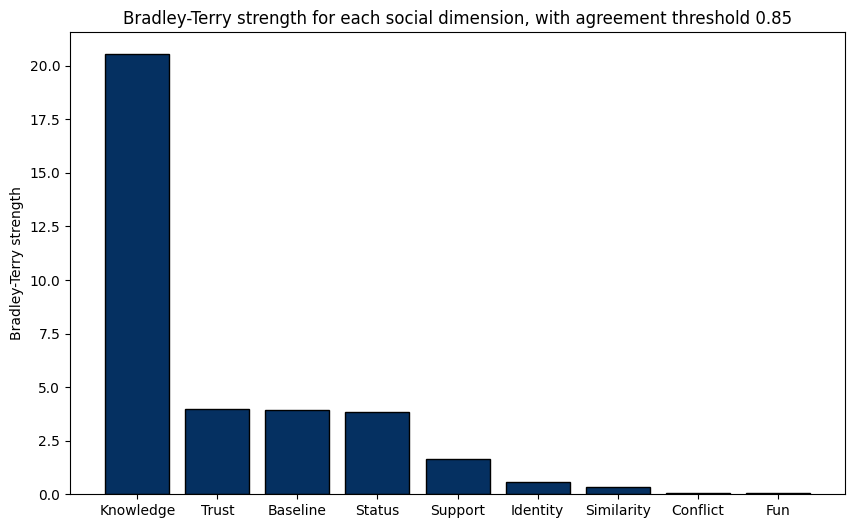

In [30]:
btl_85 = bradley_terry_df[bradley_terry_df['Threshold']==0.85]
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(btl_85['Ranking'].iloc[0],btl_85['Scores'].iloc[0],color=plt.get_cmap("RdBu")(255),edgecolor='black')
ax.set_xticklabels([dim.title() for dim in btl_85['Ranking'].iloc[0]],rotation=0)
ax.set_ylabel('Bradley-Terry strength')
ax.set_title('Bradley-Terry strength for each social dimension, with agreement threshold 0.85')
plt.savefig('../misc/images_for_report/btl_strength_scores_85_threshold.svg')
plt.show();

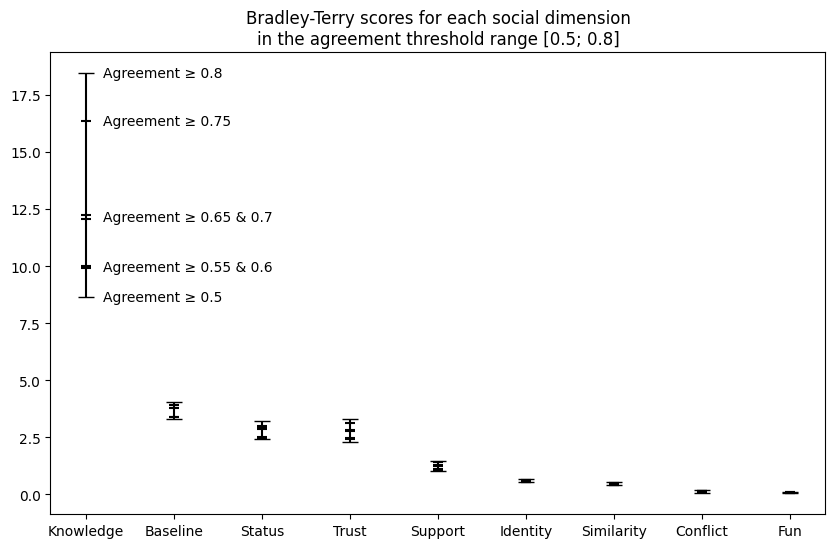

In [31]:
def make_bradley_terry_stability_plot(bradley_terry_df, threshold):
    df = bradley_terry_df[bradley_terry_df["Threshold"]<=threshold]
    scores = dict()
    for idx, row in df.iterrows():
        for score, dim in zip(row["Scores"], row["Ranking"]):
            if dim not in scores:
                scores[dim] = []
            scores[dim].append(score)

    fig, ax = plt.subplots(figsize=(10,6))
    labels, values = list(zip(*scores.items()))
    ax.errorbar(x=[l.title() for l in labels], y=[min(v) for v in values], yerr=np.array([(0, max(v)-min(v)) for v in values]).T, ls="", c="k", capsize=6)
    for i,v in enumerate(values):
        v2 = [v_ for v_ in v if v_ != min(v) and v_ != max(v)]
        ax.scatter([i]*len(v2), v2, marker="_", c="k", s=50)
        if i==0:
            annotations = dict()
            for t, v_ in zip(df["Threshold"], v):
                if round(v_) not in annotations:
                    annotations[round(v_)] = ([],[])
                annotations[round(v_)][0].append(v_)
                annotations[round(v_)][1].append(t)
            for locations, thresholds in annotations.values():
                ax.annotate(f"Agreement ≥ {' & '.join(map(str, thresholds))}", xy=(0.2, np.mean(locations)), va="center")
    ax.set_title(f"Bradley-Terry scores for each social dimension\nin the agreement threshold range [0.5; {threshold}]")
    plt.savefig('../misc/images_for_report/all_bradley_terry_values.svg')

make_bradley_terry_stability_plot(bradley_terry_df, 0.80)

### Agreement histogram

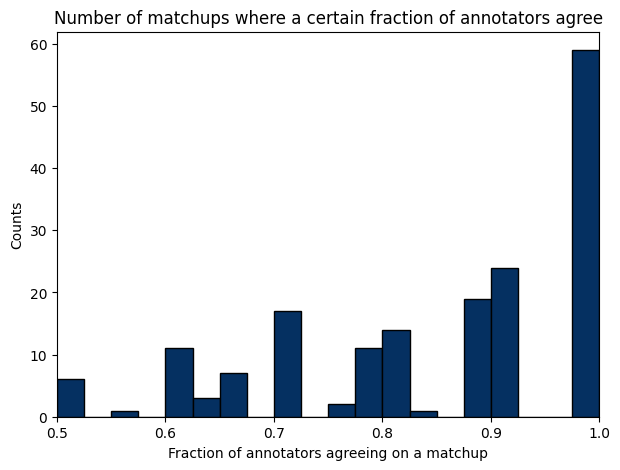

In [32]:
highest_agreement_per_sample = agreement_per_match_frac(get_matchup_results(res_rejected))
fix, ax = plt.subplots(figsize=(7,5))
ax.hist(highest_agreement_per_sample,edgecolor='black',bins=20,color=plt.get_cmap("RdBu")(255))
ax.set_xlim(0.5,1)
ax.set_xlabel('Fraction of annotators agreeing on a matchup')
ax.set_ylabel('Counts')
ax.set_title('Number of matchups where a certain fraction of annotators agree')
plt.savefig("../misc/images_for_report/annotation_agreement_matchup_histogram.svg")
plt.show();

### Agreement scores with randomly generated results 

We see our kappa is above this confidence interval

In [33]:
def perform_random_score_fleiss(res):
    samples_per_match = 10
    random_scores = []
    for i in range(get_number_of_matchups(res)):
        col1 = randint(0,samples_per_match)
        col2 = samples_per_match-col1
        random_scores.append([col1,col2])
    random_scores = np.array(random_scores)
    return cuzick_fleiss_kappa(random_scores)

In [34]:
random_samples = np.array([perform_random_score_fleiss(res_rejected) for i in range(1000)])

In [35]:
p = random_samples.mean()
n = len(random_samples)

In [36]:
random_samples.mean(),p - (norm.ppf(.975) * np.sqrt((p*(1-p))/n)),p + (norm.ppf(.975) * np.sqrt((p*(1-p))/n))

(0.3320228274326115, 0.3028342537526192, 0.36121140111260386)